This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks). 

## BSL

[Bayesian synthethic likelihood](https://doi.org/10.1080/10618600.2017.1302882) (BSL) methods sample an approximate posterior distribution based on comparison between the observed data and a [synthetic likelihood](https://www.nature.com/articles/nature09319) estimated based on repeated simulations. 

This tutorial demonstrates how to use various BSL methods for LFI in ELFI.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import elfi
from elfi.methods.bsl import pre_sample_methods, pdf_methods

seed = 1
np.random.seed(seed)

We use the MA(2) model introduced in the [ELFI tutorial](https://elfi.readthedocs.io/en/latest/usage/tutorial.html#inference-with-elfi-case-ma-2-model).

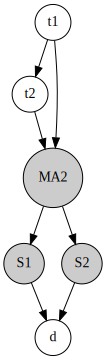

In [2]:
from elfi.examples import ma2
m = ma2.get_model(n_obs=50, true_params=[0.6, 0.2], seed_obs=seed)
elfi.draw(m)

### Tutorial example

BSL in ELFI proceeds so that we first define how the observed and simulated data are converted to approximate likelihood scores and then sample the approximate posterior distribution estimated based on the likelihood scores. Here we demonstrate the process with standard BSL.

1. Likelihood calculation setup

BSL operates on features calculated based on observed and simulated data to estimate the likelihood that the same parameter values produced the observed and simulated data. 
In practice the likelihood scores are calculated based on the observed features and a parametric distribution model estimated based on `nsim_round` simulated features.
How the observed and simulated data are converted to approximate likelihood scores thus involves the chosen feature representation, likelihood calculation method, and simulation count.

- Features

Features used in likelihood calculation must be included as observable nodes in the ELFI model. Observable nodes in our example include the simulator node `MA2` and the summaries `S1` and `S2`. To match examples used in the BSL literature, we do not use summaries but estimate likelihood scores based on the observed and simulated data.

In [3]:
feature_names = 'MA2'

As the standard likelihood calculation method models the simulated feature distribution as a multivariate normal, it is useful to visualise feature distributions to assess normality. Here we choose parameter values `params` that we believe could reproduce the observed data and visualise the distribution over features calculated based on `nsim` repeated simulations. If the feature distributions deviate from normal, a semiparametric likelihood calculation method could be more appropriate than the standard likelihood calculation method. Feature transformations can also improve normality.

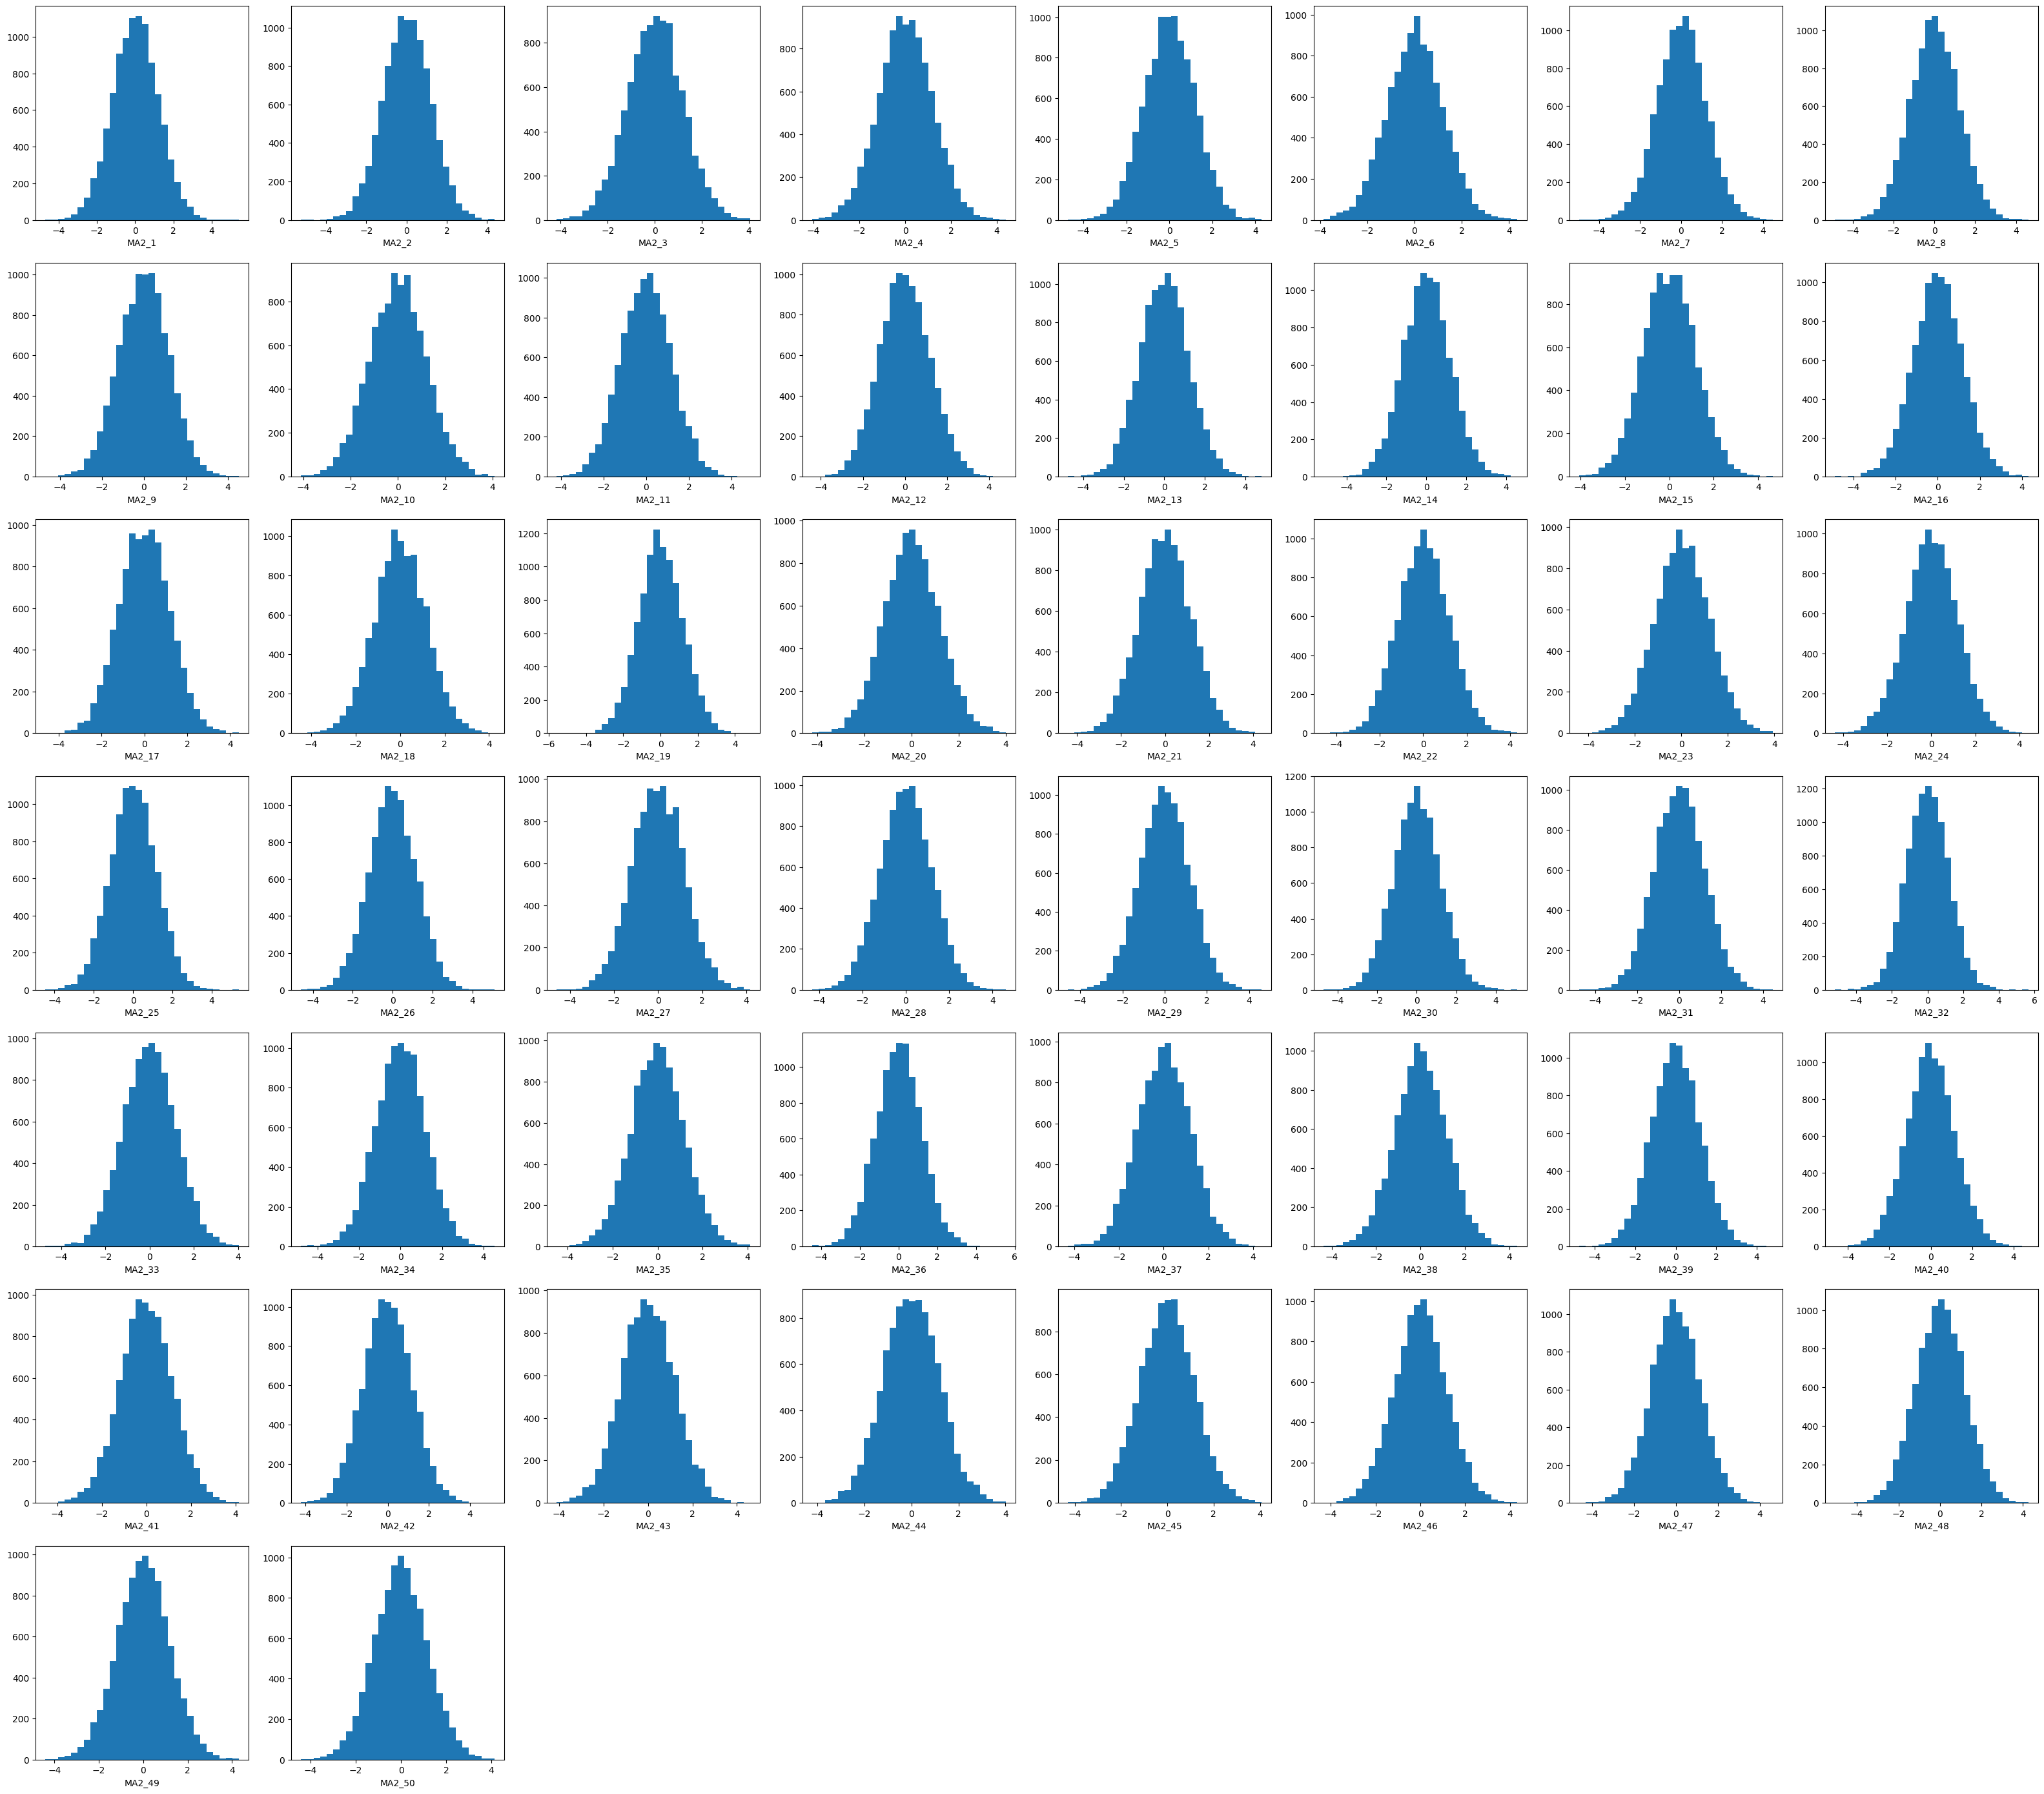

In [4]:
params = {'t1': 0.6, 't2': 0.2}
nsim = 10000
pre_sample_methods.plot_features(m, params, nsim, feature_names)

We can also visualise the sample covariance between simulated features. When the covariances between most features are close to zero, we can use likelihood calculation methods that substitute the sample covariance matrix with a sparse approximation.

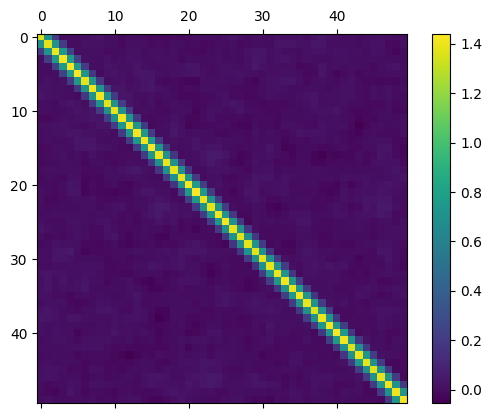

In [5]:
params = {'t1': 0.6, 't2': 0.2}
nsim = 10000
pre_sample_methods.plot_covariance_matrix(m, params, nsim, feature_names)

- Likelihood calculation method

The likelihood calculation methods available in ELFI include `standard_likelihood`, `unbiased_likelihood`, `semiparametric_likelihood`, and `robust_likelihood`. We can either choose a method from this list or provide a custom method that takes the observed and simulated data as input and returns an appropriate likelihood score.

Here we choose the standard synthetic likelihood calculation method. This method approximates the simulated feature distribution with a multivariate normal distribution.

In [6]:
likelihood = pdf_methods.standard_likelihood()

- Simulation count

BSL methods are most computationally efficient when `nsim_round` is selected so that the standard deviation between log-likelihood scores is between 1 and 2. Here we calculate the standard devitation between `M` scores calculated based on `nsim_round` features simulated with `params`.

In [7]:
params = {'t1': 0.6, 't2': 0.2}
nsim_round = 500
std_value = pre_sample_methods.log_SL_stdev(m, params, nsim_round, feature_names, likelihood=likelihood, M=100)
std_value

1.7043372835513626

2. BSL sampler

With `feature_names`, `likelihood`, and `nsim_round`, we have decided how the likelihood scores are calculated and can create a `BSL` instance to sample the approximate posterior distribution estimated based on the selected likelihood scores.

In [8]:
standard_bsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

We can see here that `feature_names` and `likelihood` are optional parameters. `feature_names` defaults to all summary nodes in model `m` and `likelihood` defaults to the standard synthetic likelihood estimation method. Optional parameters also include `batch_size` which defaults to the simulation count `nsim_round`.

To proceed, we call the `sample` method to set sampler parameters and sample a chain from the approximate posterior distribution. BSL uses MCMC sampling with a Metropolis-Hastings step. Required parameters are the sample size and a covariance matrix for the proposal distribution, while optional parameters include, for example, the burn-in period `burn_in` and initial parameter values `params0`. Here we initialise the chain to the true parameter values.

In [9]:
mcmc_iterations = 2000  # sample size
est_post_cov = np.array([[0.02, 0.01], [0.01, 0.02]])  # covariance matrix for the proposal distribution
params0 = [0.6, 0.2]
res = standard_bsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [10]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 1000000
MCMC Acceptance Rate: 0.219
Parameter                Mean               2.5%              97.5%
t1:                     0.426              0.142              0.740
t2:                     0.234             -0.044              0.467


As MCMC draws correlated samples, it is useful to estimate the effective sample size (ESS) as an estimate of the equivalent number of independent iterations that the MCMC chain represents.

In [11]:
res.compute_ess()

{'t1': 69.85051011126637, 't2': 86.11215292286599}

We can also visualise the sample.

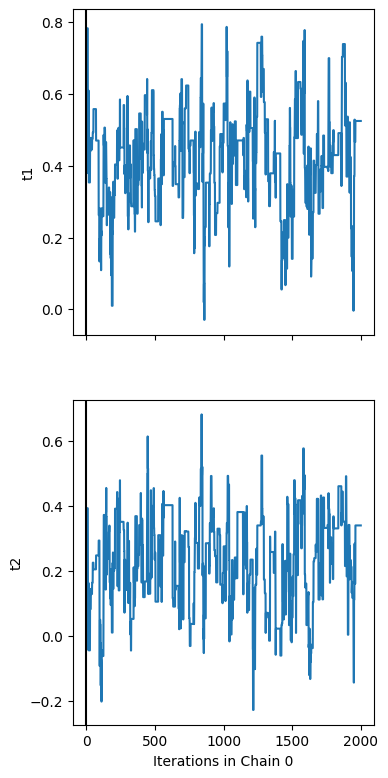

In [12]:
res.plot_traces();

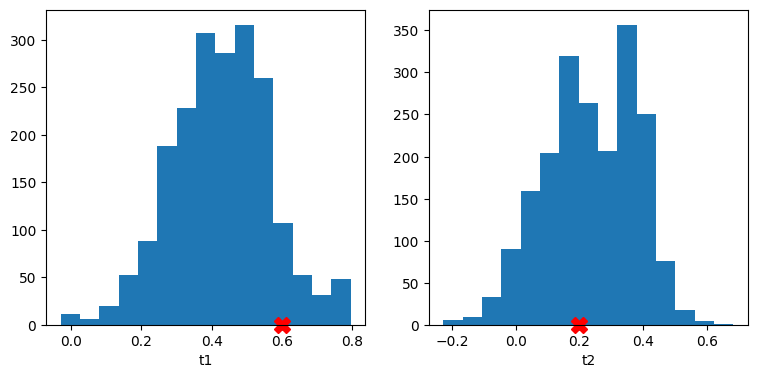

In [13]:
mbins = 15
res.plot_marginals(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

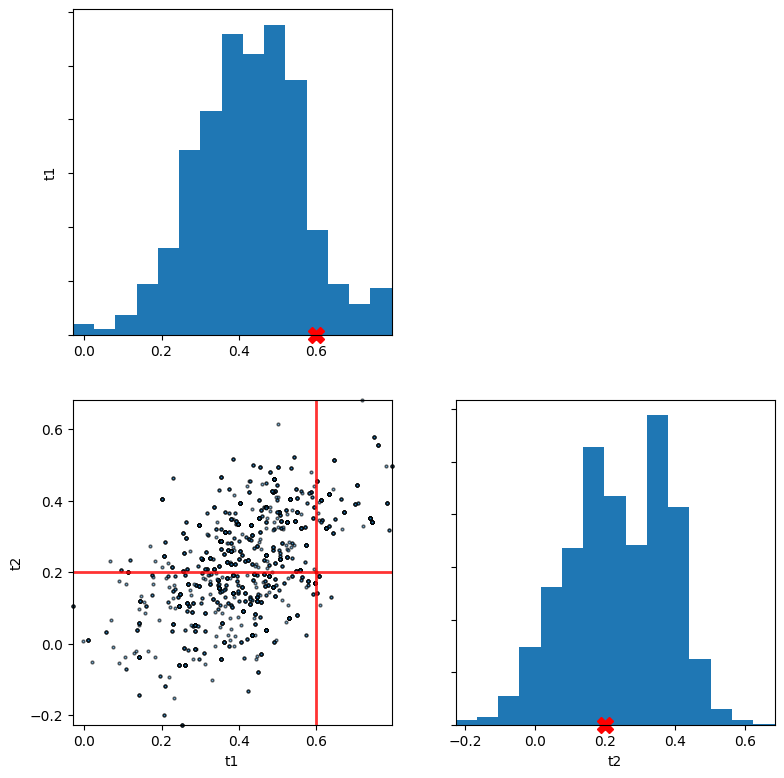

In [14]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

This concludes the standard BSL example. Extensions to the standard method are implemented as extensions to the likelihood function or as alternative likelihood functions.

### BSLasso

[BSLasso](https://doi.org/10.1080/10618600.2018.1537928) uses the graphical lasso (glasso) to accelerate BSL. In practice the sample covariance matrix calculated based on simulated features is substituted with a sparse estimate, and with fewer parameters to estimate, we can reduce the simulation count without an increase in the standard deviation between synthetic log-likelihood scores.

Here we use the standard synthetic likelihood calculation method with `shrinkage='glasso'` and `penalty` options. `shrinkage` selects the penalised covariance matrix estimation method and `penalty` is a regularisation parameter used in estimation. We can choose one or more simulation counts and use the `select_penalty` method to find a parameter value that results in estimated log-likelihood standard deviation closest to `sigma` for each simulation count.

In [15]:
likelihood = pdf_methods.standard_likelihood()
shrinkage = 'glasso'
sigma = 1.5
nsim = [100, 300, 500]
params = {'t1': 0.6, 't2': 0.2}
penalty, std_value = pre_sample_methods.select_penalty(m, nsim, params, feature_names, sigma=sigma, shrinkage=shrinkage, likelihood=likelihood, seed=seed)

In [16]:
std_value

array([1.42852368, 1.48559756, 1.47654265])

In [17]:
penalty

array([0.06720551, 0.03688317, 0.01356856])

Let us update the likelihood calculation method and simulation count:

In [18]:
likelihood = pdf_methods.standard_likelihood(shrinkage='glasso', penalty=penalty[1])
nsim_round = nsim[1]

Sample:

In [19]:
bslasso = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [20]:
res = bslasso.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [21]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 596700
MCMC Acceptance Rate: 0.371
Parameter                Mean               2.5%              97.5%
t1:                     0.465              0.126              0.821
t2:                     0.205             -0.186              0.698


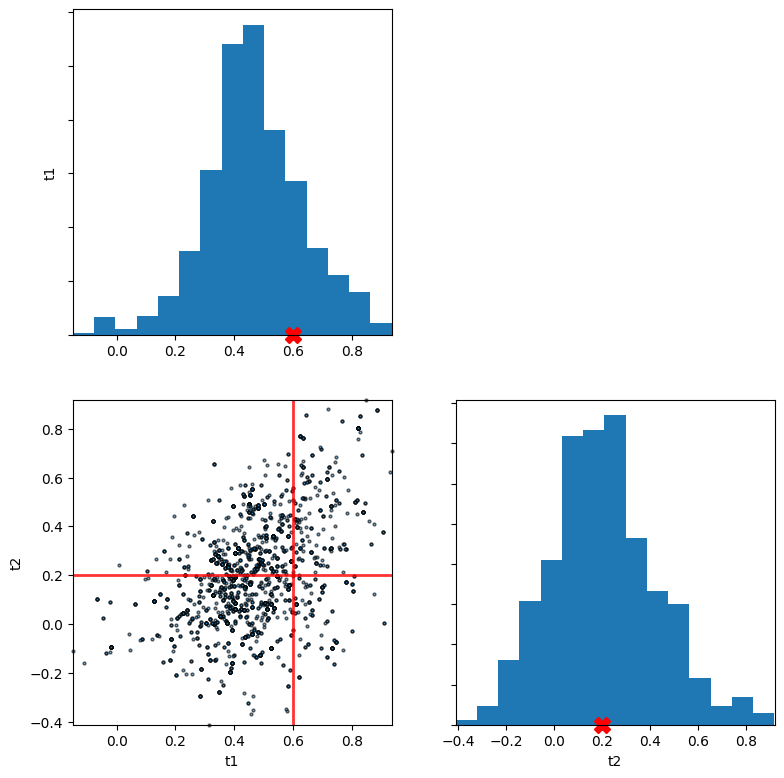

In [22]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

### wBSL

[Whitening BSL](https://doi.org/10.1080/10618600.2021.1979012) (wBSL) uses a whitening transformation to decorrelate the selected features to allow more shrinkage to be applied. Here we estimate the transformation matrix based on `nsim` features simulated with `params` that we believe could reproduce the observed data. Whitening transformations can be used with both standard and semiparametric likelihood calculation methods, but the transformations are different, so the likelihood type is also communicated to the estimation method.

In [23]:
likelihood_type = 'standard'
nsim = 20000
params = {'t1': 0.6, 't2': 0.2}
W = pre_sample_methods.estimate_whitening_matrix(m, nsim, params, feature_names, likelihood_type=likelihood_type)

We then choose the sparse estimation method with `shrinkage` and use `select_penalty` to find a suitable `penalty` parameter as outlined in the previous example. It has been found that the Warton shrinkage estimator works better than graphical lasso when whitening is used, so it is recommended to set `shrinkage='warton'` when a whitening transformation is used. The whitening transformation is included as an additional input to `select_penalty`.

In [24]:
likelihood = pdf_methods.standard_likelihood()
shrinkage = 'warton'
sigma = 1.5
nsim = [100, 300]
params = {'t1': 0.6, 't2': 0.2}
penalty, std_value = pre_sample_methods.select_penalty(m, nsim, params, feature_names, whitening=W, sigma=sigma, shrinkage=shrinkage, likelihood=likelihood, seed=seed)

In [25]:
std_value

array([1.47373831, 1.48720947])

In [26]:
penalty

array([0.26, 0.6 ])

Let us update the likelihood calculation method and simulation count:

In [27]:
likelihood = pdf_methods.standard_likelihood(whitening=W, shrinkage=shrinkage, penalty=penalty[0])
nsim_round = nsim[0]

Sample:

In [28]:
wbsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [29]:
res = wbsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [30]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 200000
MCMC Acceptance Rate: 0.281
Parameter                Mean               2.5%              97.5%
t1:                     0.440              0.134              0.794
t2:                     0.245             -0.060              0.545


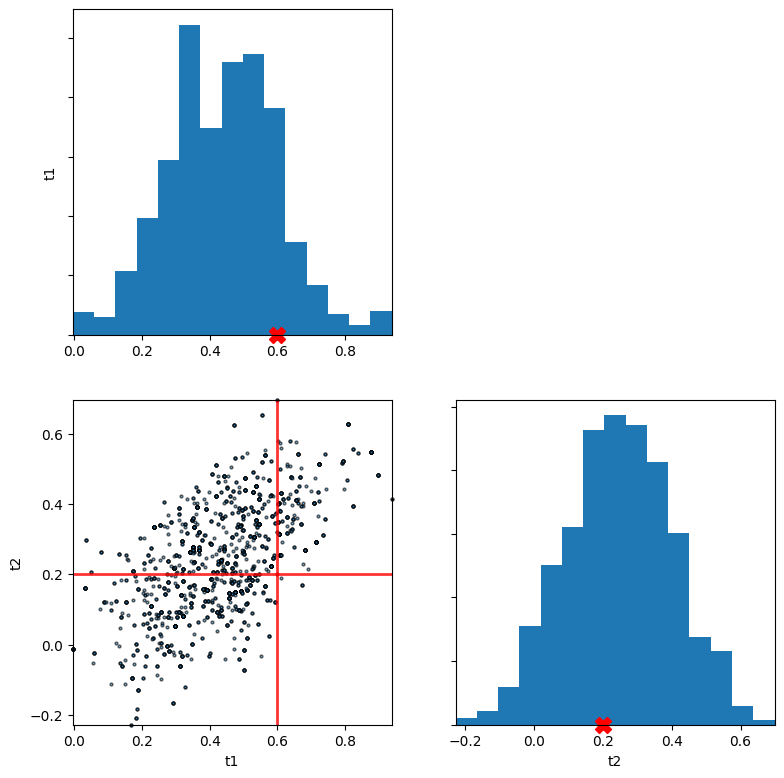

In [31]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

### SemiBSL

The previous examples all used `standard_likelihood` which models the simulated feature distribution as multivariate normal. Alternatives include the semi-parametric synthetic likelihood estimator that relaxes the normality assumption.


In [32]:
likelihood = pdf_methods.semiparametric_likelihood()
nsim_round = 500

Sample:

In [33]:
semibsl = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [34]:
res = semibsl.sample(mcmc_iterations, est_post_cov, params0=params0)

Progress [==================================================] 100.0% Complete


In [35]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 1000000
MCMC Acceptance Rate: 0.254
Parameter                Mean               2.5%              97.5%
t1:                     0.410              0.141              0.705
t2:                     0.213             -0.043              0.499


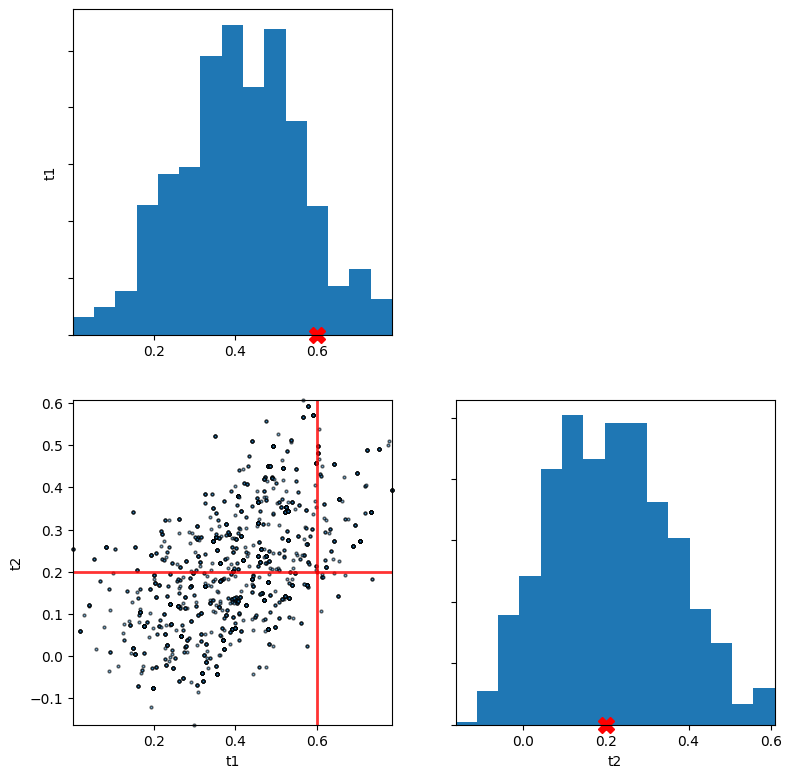

In [36]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

### R-BSL

[Robust BSL](https://doi.org/10.1080/10618600.2021.1875839) (R-BSL) methods are able to perform useful parameter inference even if the model is misspecified. A simulator model is said to be misspecified in the BSL sense if it is unable to replicate the observed features. R-BSL uses a misspecification robust likelihood calculation method that adds free parameters to absorb the impact of model misspecification. The free parameters adjust either the sample mean (R-BSL-M) or the sample covariance (R-BSL-V). R-BSL samples both the simulator parameters and the free parameters `gamma`.

We run this example with summarised data.

In [37]:
feature_names = ['S1', 'S2']

Let us start with mean adjustment:

In [38]:
likelihood = pdf_methods.robust_likelihood("mean")
nsim_round = 500

In [39]:
rbsl_m = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

R-BSL uses a slice sampler for the `gamma` parameters, and `sample` is now used to set both the MCMC and slice sampler parameters. The slice sampler parameters include step size `w`, maximum iteration count `max_iter`, and a parameter `tau` that scales the prior distribution used for `gamma`. Here we use the default values for `w` and `max_iter` but set the prior distribution scale `tau` to a small value to indicate that we do not believe that the model is misspecified.


In [40]:
res = rbsl_m.sample(mcmc_iterations, est_post_cov, params0=params0, tau=0.1)

Progress [==================================================] 100.0% Complete


In [41]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 977000
MCMC Acceptance Rate: 0.658
Parameter                Mean               2.5%              97.5%
t1:                     0.383             -0.022              0.820
t2:                     0.219             -0.226              0.935


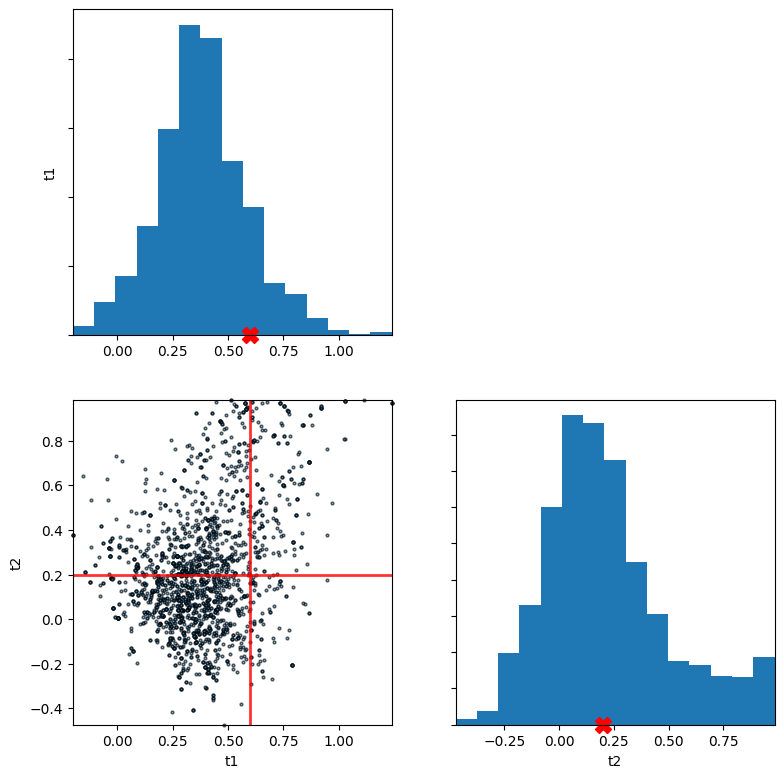

In [42]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

We can also visualise the sampled `gamma` parameters to see how the sample mean was adjusted in the accepted sample. Each feature is adjusted separately so the `gamma` parameter dimension matches the selected feature dimension.

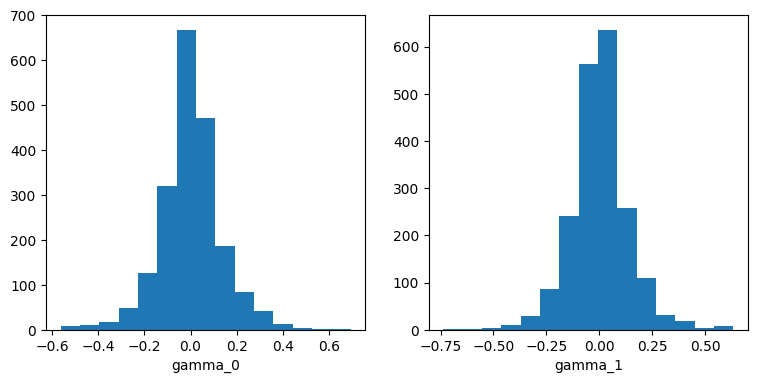

In [43]:
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_m.observed.size)], np.transpose(res.outputs['gamma'])))
elfi.visualization.visualization.plot_marginals(gamma_dict, bins=mbins);

R-BSL with variance adjustment follows the same process:

In [44]:
likelihood = pdf_methods.robust_likelihood("variance")

In [45]:
rbsl_v = elfi.BSL(m, nsim_round, feature_names=feature_names, likelihood=likelihood, seed=seed)

In [46]:
res = rbsl_v.sample(mcmc_iterations, est_post_cov, params0=params0, tau=0.1)

Progress [==================================================] 100.0% Complete


In [47]:
res

Method: BSL
Number of samples: 2000
Number of simulations: 973500
MCMC Acceptance Rate: 0.675
Parameter                Mean               2.5%              97.5%
t1:                     0.412              0.007              0.888
t2:                     0.166             -0.356              0.778


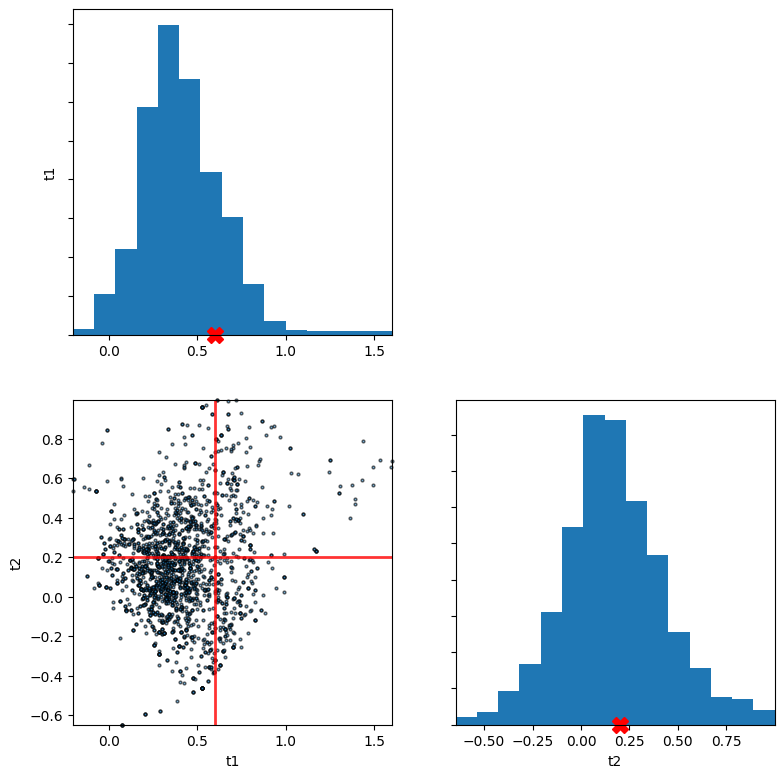

In [48]:
res.plot_pairs(reference_value={'t1': 0.6, 't2': 0.2}, bins=mbins);

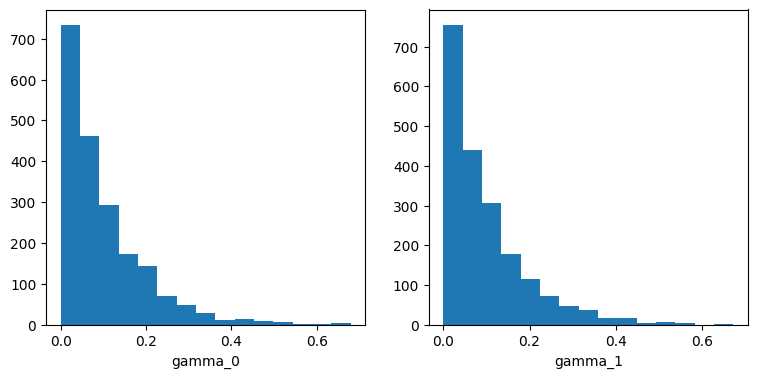

In [49]:
gamma_dict = dict(zip(['gamma_{}'.format(index) for index in range(rbsl_v.observed.size)], np.transpose(res.outputs['gamma'])))
elfi.visualization.visualization.plot_marginals(gamma_dict, bins=mbins);

## Parallelising simulations

To parallelise the simulated feature generation in BSL, we can choose a batch size that is smaller than the simulation count and let an appropriate ELFI client run batches in parallel.

In [50]:
elfi.set_client('multiprocessing')
bsl = elfi.BSL(m, 200, batch_size=50, seed=seed)
res = bsl.sample(mcmc_iterations, est_post_cov, bar=False)